In [1]:
from keras.models import model_from_json
import keras
from keras.optimizers import Adam
import numpy as np
import copy
import matplotlib.pyplot as plt
np.random.seed(0)

Using TensorFlow backend.


In [2]:
# Load model
with open("trained_model_128px_crop/model.json") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load weights
loaded_model.load_weights("trained_model_128px_crop/model_weights.h5")
print("Model has been loaded")

Model has been loaded


In [3]:
loaded_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [4]:
# Load the data
print("Loading the data ...\n\n")
images = np.load("cropped_images.npy")
images_gt = np.load("cropped_images_gt.npy")
patient_ids = np.load("patient_ids.npy")

print("Image data has size: {}".format(images.shape))
print("Ground truth has size: {}".format(images_gt.shape))
print("Patient ids array has size: {}\n\n".format(patient_ids.shape))

# For now keep only the labels of the Left Venctricle (removes RV, myocardium)
images_gt[images_gt != 3] = 0
images_gt[images_gt == 3] = 1

# Scale data and convert to 4D (requirement: for the conv2d training)
images = images / np.amax(images) # scale
images = np.reshape(images, newshape=(*images.shape, 1))
images_gt = np.reshape(images_gt, newshape=(*images_gt.shape, 1))

print("Reshaped image data has size: {}".format(images.shape))
print("Reshaped ground truth has size: {}\n\n".format(images_gt.shape))

# Split dataset to train/valid/test based on patient ids (doesnt mix patient slices)
# First split the ids
id_list = np.arange(1, np.amax(patient_ids)+1)
np.random.seed(0) # seed for reproducability
np.random.shuffle(id_list)
train_ids = np.sort(id_list[:70]) # 70% - 15% - 15% split
valid_ids = np.sort(id_list[70:85])
test_ids = np.sort(id_list[85:])

# Create the id masks
train_msk = np.in1d(patient_ids, train_ids)
valid_msk = np.in1d(patient_ids, valid_ids)
test_msk = np.in1d(patient_ids, test_ids)

# Now split the images based on the masks
train_set = images[train_msk]
train_set_gt = images_gt[train_msk]
train_id_array = patient_ids[train_msk]

valid_set = images[valid_msk]
valid_set_gt = images_gt[valid_msk]
valid_id_array = patient_ids[valid_msk]

test_set = images[test_msk]
test_set_gt = images_gt[test_msk]
test_id_array = patient_ids[test_msk]

Loading the data ...


Image data has size: (1902, 128, 128)
Ground truth has size: (1902, 128, 128)
Patient ids array has size: (1902,)


Reshaped image data has size: (1902, 128, 128, 1)
Reshaped ground truth has size: (1902, 128, 128, 1)




In [5]:
# prediction = loaded_model.predict(valid_set, batch_size=64, verbose=1)
prediction = np.load("prediction_first_experiment.npy")

# Scale prediction to 0 to 1
prediction /= np.amax(prediction)

In [6]:
print(prediction.shape)

(298, 128, 128, 1)


In [7]:
# np.save("prediction_first_experiment", prediction)

# Example visualization of a slice for different threshold values

C:\Users\Amenofis\Anaconda2\envs\team_challenge\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


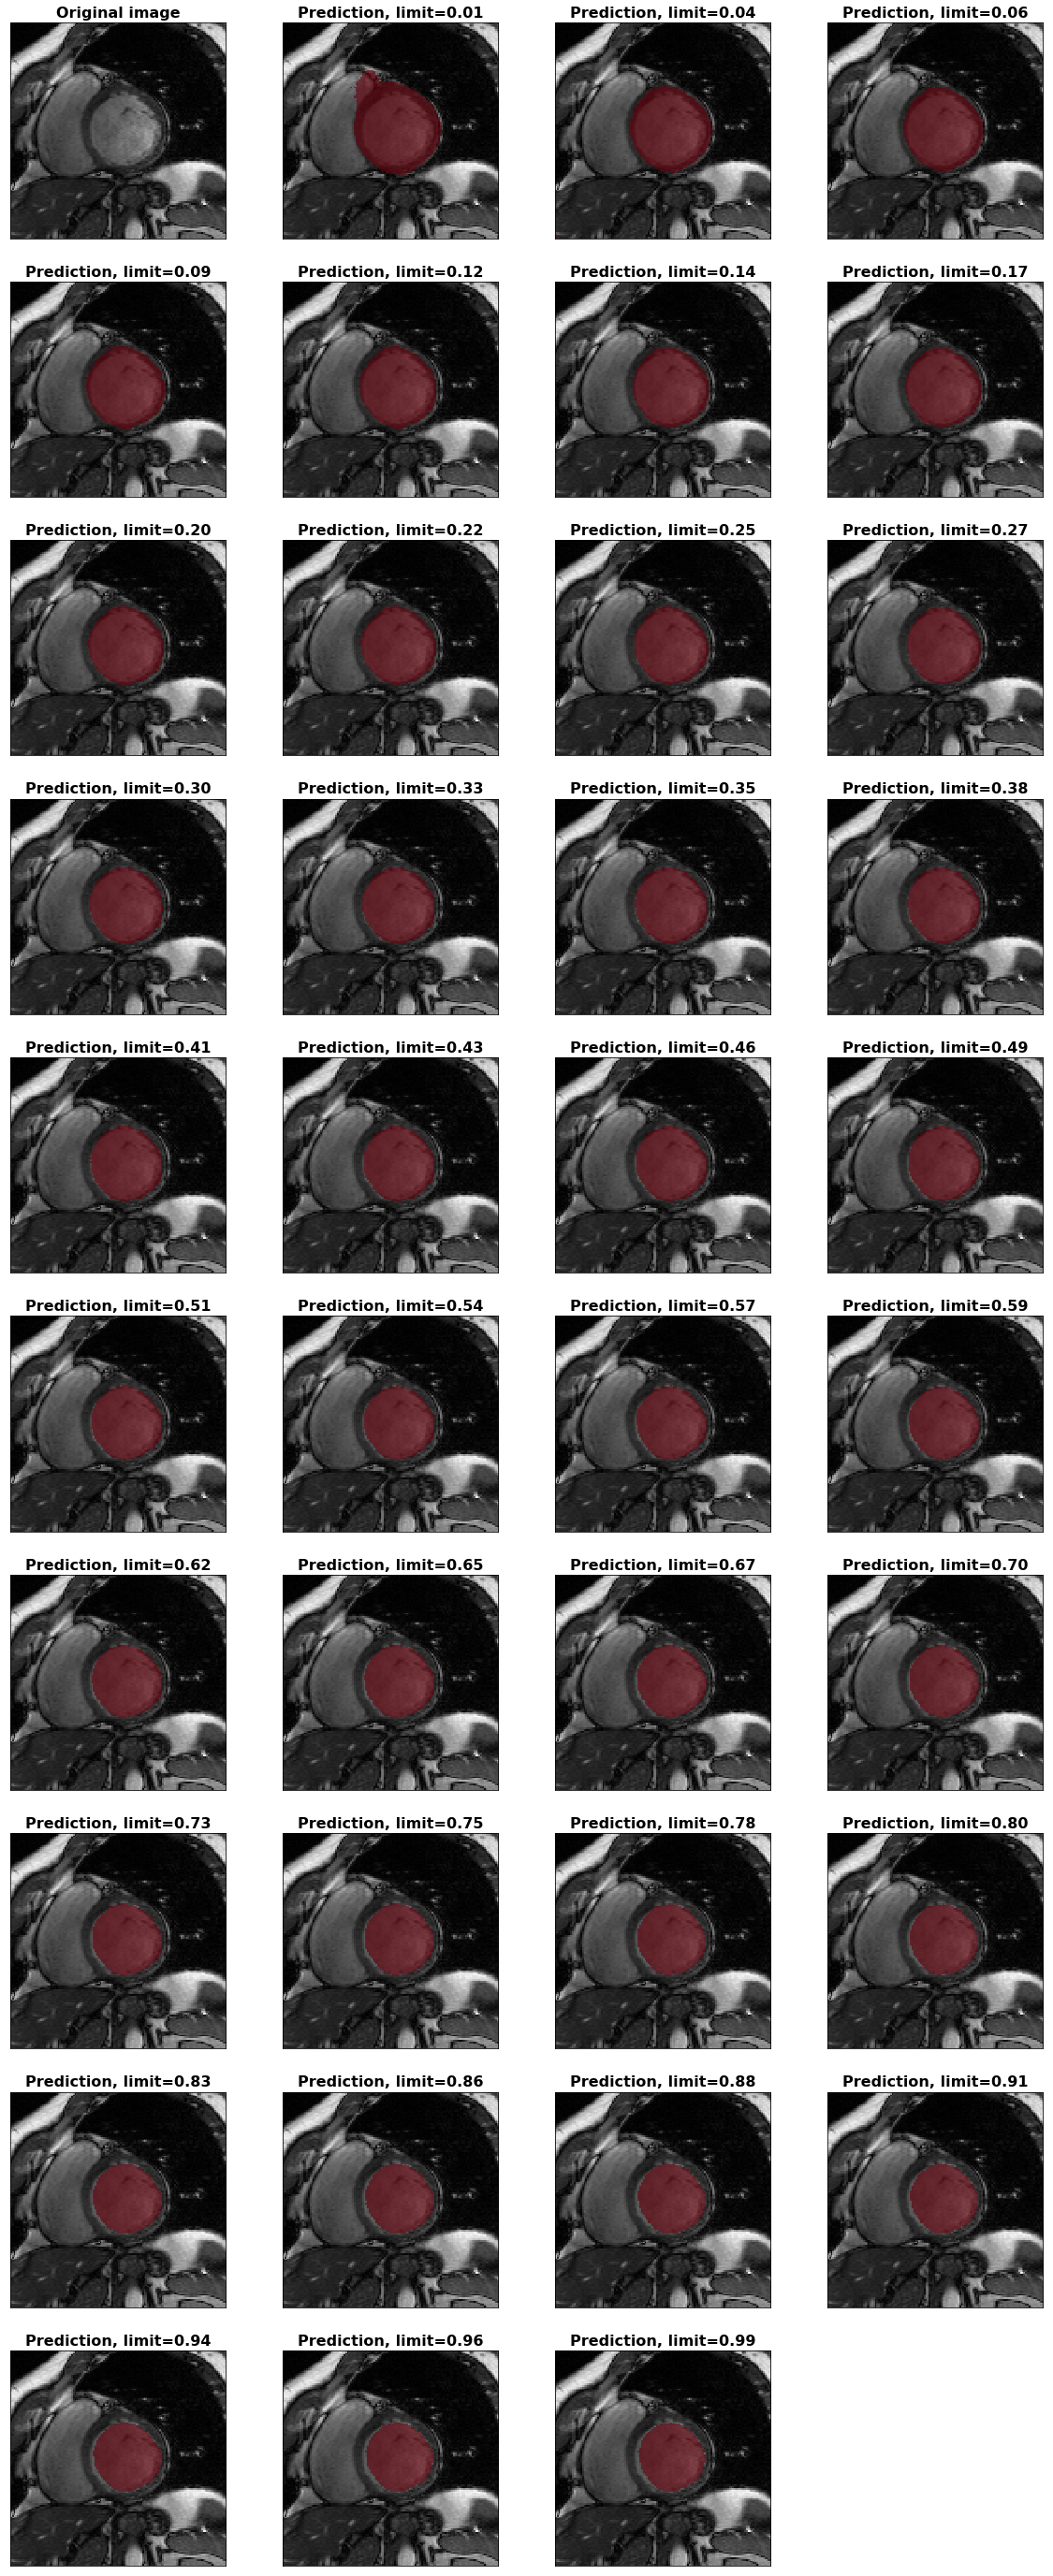

In [8]:
limit = np.linspace(0.01,0.99, 38)

plt.rcParams["figure.figsize"] = (20,50)
nrows = 10
ncols = 4

plt.subplot(nrows, ncols, 1)
plt.imshow(valid_set[0,:,:,0], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("Original image", fontsize=16, fontweight="bold")

plt.subplot(nrows, ncols, 2)
plt.imshow(valid_set[0,:,:,0], cmap="gray")
plt.imshow(np.ma.masked_where(valid_set_gt[0,:,:,0]!=1,valid_set_gt[0,:,:,0]==1), alpha=0.6, cmap="Reds", clim=(0,1))
plt.xticks([])
plt.yticks([])
plt.title("Ground Truth", fontsize=16, fontweight="bold")

for i in range(len(limit)):
    thresholded = copy.deepcopy(prediction)
    thresholded[thresholded>limit[i]] = 1
    thresholded[thresholded<=limit[i]] = 0

    plt.subplot(nrows, ncols, i+2)
    plt.imshow(valid_set[0,:,:,0], cmap="gray")
    plt.imshow(np.ma.masked_where(thresholded[0,:,:,0]!=1,thresholded[0,:,:,0]==1), alpha=0.6, cmap="Reds", clim=(0,1))
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Prediction, limit={limit[i]:.2f}", fontsize=16, fontweight="bold")

plt.show()

In [9]:
def dice_score(ground_truth, prediction):
    true_positive_mask = np.logical_and(ground_truth==1, prediction==1)
    false_positive_mask = np.logical_and(ground_truth==0, prediction==1)
    false_negative_mask = np.logical_and(ground_truth==1, prediction==0)

    TP = np.count_nonzero(true_positive_mask)
    FP = np.count_nonzero(false_positive_mask)
    FN = np.count_nonzero(false_negative_mask)
    DSC = 2*TP / (2*TP + FP + FN)
    # print("The overall dice score is: ", DSC)
    return DSC

# Tuning threshold using the validation set (training can also be used!)

In [10]:
limits = np.linspace(0.1, 0.99, 100)

dice_scores = []
Lv_pixels_scores = []
lv_px_gt = np.count_nonzero(valid_set_gt)
for limit in limits:
    thresholded = copy.deepcopy(prediction)
    thresholded[thresholded>limit] = 1
    thresholded[thresholded<=limit] = 0
    dice_scores.append(dice_score(valid_set_gt[:,:,:,0], thresholded[:,:,:,0]))
print(dice_scores)

[0.6369847563059676, 0.6440765917700171, 0.6506983863208992, 0.6567708489777601, 0.6623867150301201, 0.6677737456752852, 0.6727791908101695, 0.6773192257913556, 0.6815443753866093, 0.6855198336354437, 0.6894170448758485, 0.6930055362672422, 0.69656113568027, 0.6999348934853624, 0.7029739812420689, 0.706141436230925, 0.7090951855821952, 0.7120697805987616, 0.7147495289556051, 0.7174820553229846, 0.7200131984939576, 0.7225462830540405, 0.7249813297201142, 0.7272904471799401, 0.7295225011880564, 0.7317633428810241, 0.7339624159993562, 0.7361267625544771, 0.7381977380518059, 0.7402793683598144, 0.7423070170782792, 0.7443642293477993, 0.7463248594073733, 0.7482259484808427, 0.7499596602357497, 0.7517791433961559, 0.7534488430292355, 0.7551010606196659, 0.7567624178392939, 0.7585466403876298, 0.7601099861990497, 0.7616765454795187, 0.7631918013749142, 0.764574758123296, 0.7660947178004436, 0.7675048124480566, 0.769064954766935, 0.770472572896883, 0.7718096518210251, 0.7732614406193834, 0.774

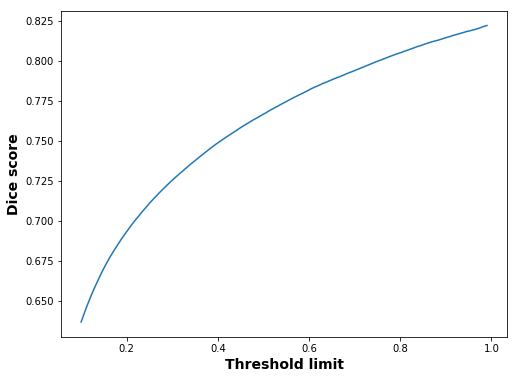

In [11]:
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(limits, dice_scores)
plt.xlabel("Threshold limit", fontsize=14, fontweight="bold")
plt.ylabel("Dice score", fontsize=14, fontweight="bold")
plt.show()

In [12]:
a = np.count_nonzero(valid_set_gt==1)
b = np.count_nonzero(valid_set_gt==0)
print(a, b)
print(f"Percentage of LV pixels to background: {a/b*100:.2f}%")

190169 4692263
Percentage of LV pixels to background: 4.05%


# EF PART

In [13]:
import SimpleITK as sitk
import glob
import os

## Spacing and num. of z slices for each patient

In [14]:
# HOW THE DATA ARE ACTUALLY STORED IN THE ARRAYS (they are partitioned)
id_list_correct_order = np.array([])
id_list_correct_order = np.append(id_list_correct_order, sorted(train_ids))
id_list_correct_order = np.append(id_list_correct_order, sorted(valid_ids))
id_list_correct_order = np.append(id_list_correct_order, sorted(test_ids))

# Print the spacing for each patient
spacing = []
slices = []
fpath = './Data'
for folder in os.listdir(fpath):
    print(folder)
    once = True
    for file in os.listdir(fpath+'/'+folder):
        if ('frame' in file) and once:
            fullpath = '/'.join((fpath,folder,file)) 
            im = sitk.ReadImage(fullpath)
            spac = im.GetSpacing()
            slic= sitk.GetArrayFromImage(im).shape[0]
            spacing.append(spac)
            slices.append(slic)
            once = False
            print(spac)
            print(slic)
            
# Re-order spacing/slices based on shuffled ID list
spacing = np.array(spacing)
slices = np.array(slices)

patient001
(1.5625, 1.5625, 10.0)
10
patient002
(1.3671875, 1.3671875, 10.0)
10
patient003
(1.5625, 1.5625, 10.0)
10
patient004
(1.3671875, 1.3671875, 10.0)
10
patient005
(1.40625, 1.40625, 10.0)
10
patient006
(1.7578125, 1.7578125, 10.0)
11
patient007
(1.875, 1.875, 10.0)
10
patient008
(1.5625, 1.5625, 10.0)
10
patient009
(1.3671900033950806, 1.3671900033950806, 10.0)
10
patient010
(1.5625, 1.5625, 10.0)
10
patient011
(1.4843800067901611, 1.4843800067901611, 10.0)
9
patient012
(1.5625, 1.5625, 10.0)
10
patient013
(1.4453099966049194, 1.4453099966049194, 10.0)
10
patient014
(1.3671900033950806, 1.3671900033950806, 10.0)
10
patient015
(1.3671900033950806, 1.3671900033950806, 10.0)
9
patient016
(1.4453099966049194, 1.4453099966049194, 10.0)
10
patient017
(1.5625, 1.5625, 10.0)
9
patient018
(1.3671900033950806, 1.3671900033950806, 10.0)
8
patient019
(1.6406199932098389, 1.6406199932098389, 10.0)
11
patient020
(1.7578099966049194, 1.7578099966049194, 10.0)
8
patient021
(1.6796875, 1.679687

In [15]:
slices

array([10, 10, 10, 10, 10, 11, 10, 10, 10, 10,  9, 10, 10, 10,  9, 10,  9,
        8, 11,  8, 10,  7,  9,  8,  9, 10, 10, 10, 11, 10, 10, 10, 10, 10,
       13,  8,  7,  8,  9, 10,  6,  9, 12,  9,  8,  9,  9,  8,  7, 10, 10,
        8,  7,  8,  9,  9,  8,  9,  9,  9,  9, 10,  8, 10,  8,  9, 10,  7,
        7,  6, 10,  8,  7,  8, 14,  8,  8,  8,  9,  6, 17, 16,  6, 12, 15,
        7,  8, 16,  6,  7,  8, 15, 10, 10, 14, 18,  8,  7, 16,  8])

In [16]:
print(spacing.shape)
print(spacing[:10])

(100, 3)
[[ 1.5625     1.5625    10.       ]
 [ 1.3671875  1.3671875 10.       ]
 [ 1.5625     1.5625    10.       ]
 [ 1.3671875  1.3671875 10.       ]
 [ 1.40625    1.40625   10.       ]
 [ 1.7578125  1.7578125 10.       ]
 [ 1.875      1.875     10.       ]
 [ 1.5625     1.5625    10.       ]
 [ 1.36719    1.36719   10.       ]
 [ 1.5625     1.5625    10.       ]]


## Ground truth for ED,ES and EF in validation set

In [17]:
voxelvolume = spacing[:,0]*spacing[:,1]*spacing[:,2]

In [18]:
pointer = 0
ED_volume = []
ES_volume = []
EF_gt = []
for ID in valid_ids:
    ID = ID - 1 # because patient numbering starts from 1 !!!
    ED = np.count_nonzero(valid_set_gt[pointer:pointer+slices[ID]]) * voxelvolume[ID]
    ED_volume.append(ED)
    pointer += slices[ID]
    ES = np.count_nonzero(valid_set_gt[pointer:pointer+slices[ID]]) * voxelvolume[ID]
    ES_volume.append(ES)
    pointer += slices[ID]
    EF = (ED-ES)/ED
    EF_gt.append(EF)
    print("Patient: ", ID+1)
    print("EF gt: ", EF)

Patient:  20
EF gt:  0.17290429498688029
Patient:  21
EF gt:  0.6755923401493021
Patient:  26
EF gt:  0.5002461235540241
Patient:  30
EF gt:  0.7458881578947368
Patient:  38
EF gt:  0.5145533286332964
Patient:  40
EF gt:  0.504681230494873
Patient:  47
EF gt:  0.16735594154948993
Patient:  50
EF gt:  0.1644396551724138
Patient:  70
EF gt:  0.6242159803654214
Patient:  73
EF gt:  0.6298150163220892
Patient:  78
EF gt:  0.6298787210584345
Patient:  82
EF gt:  0.5497897764992256
Patient:  95
EF gt:  0.5536349269063611
Patient:  98
EF gt:  0.5611055611055611
Patient:  99
EF gt:  0.47251873722461957


In [19]:
limit = 0.50
thresholded = copy.deepcopy(prediction)
thresholded[thresholded>limit] = 1
thresholded[thresholded<=limit] = 0

pointer = 0
ED_volume_pred = []
ES_volume_pred = []
EF_pred = []
for ID in valid_ids:
    ID = ID - 1 # because patient numbering starts from 1 !!!
    ED = np.count_nonzero(thresholded[pointer:pointer+slices[ID]]) * voxelvolume[ID]
    ED_volume_pred.append(ED)
    pointer += slices[ID]
    ES = np.count_nonzero(thresholded[pointer:pointer+slices[ID]]) * voxelvolume[ID]
    ES_volume_pred.append(ES)
    pointer += slices[ID]
    EF = (ED-ES)/ED
    EF_pred.append(EF)
    
    print("Patient: ", ID+1)
    print("EF prediction: ", EF)

Patient:  20
EF prediction:  0.12276080084299264
Patient:  21
EF prediction:  0.3523809523809524
Patient:  26
EF prediction:  0.31109719177367157
Patient:  30
EF prediction:  0.23023524874662554
Patient:  38
EF prediction:  0.30398638217014373
Patient:  40
EF prediction:  0.3325664327619923
Patient:  47
EF prediction:  0.23683744017018263
Patient:  50
EF prediction:  0.24956875733112538
Patient:  70
EF prediction:  0.4180210325047801
Patient:  73
EF prediction:  0.3747917823431427
Patient:  78
EF prediction:  0.42694587119715527
Patient:  82
EF prediction:  0.36716828244827093
Patient:  95
EF prediction:  0.39976504153729964
Patient:  98
EF prediction:  0.1158222541621751
Patient:  99
EF prediction:  0.26240953597275435


In [20]:
EF_gt = np.array(EF_gt)
EF_pred = np.array(EF_pred)
metric = sum(abs(EF_gt - EF_pred) / EF_gt * 100)  / len(EF_gt)

print(f"The overall metric(?) is: {metric:.2f}%")

The overall metric(?) is: 42.84%


# Find optimal threshold

In [21]:
limits = np.linspace(1e-08,1e-02)

metrics = []
for limit in limits:
    thresholded = copy.deepcopy(prediction)
    thresholded[thresholded>limit] = 1
    thresholded[thresholded<=limit] = 0

    pointer = 0
    ED_volume_pred = []
    ES_volume_pred = []
    EF_pred = []
    for ID in valid_ids:
        ID = ID - 1 # because patient numbering starts from 1 !!!
        ED = np.count_nonzero(thresholded[pointer:pointer+slices[ID]]) * voxelvolume[ID]
        ED_volume_pred.append(ED)
        pointer += slices[ID]
        ES = np.count_nonzero(thresholded[pointer:pointer+slices[ID]]) * voxelvolume[ID]
        ES_volume_pred.append(ES)
        pointer += slices[ID]
        EF = (ED-ES)/ED
        EF_pred.append(EF)

    EF_gt = np.array(EF_gt)
    EF_pred = np.array(EF_pred)
    metric = sum(abs(EF_gt - EF_pred) / EF_gt) / len(EF_gt)
    metrics.append(metric)

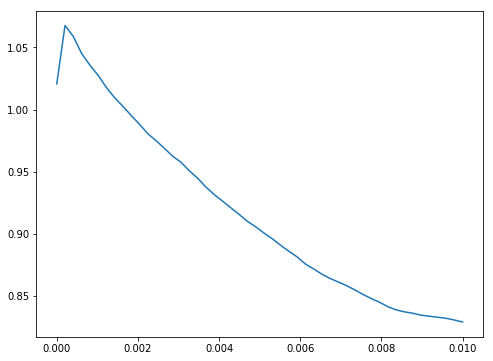

In [22]:
plt.plot(limits, metrics)
plt.show()

## I would expect a maximum value around limit=0.5.. Look below to see what is happening!

# --------------------------------------------------------------------------------------------------------------
# Visualize (unthresholded) predictions on validation set

In [23]:
ID = valid_ids[1]
slic = slices[ID]
print(slic)

7


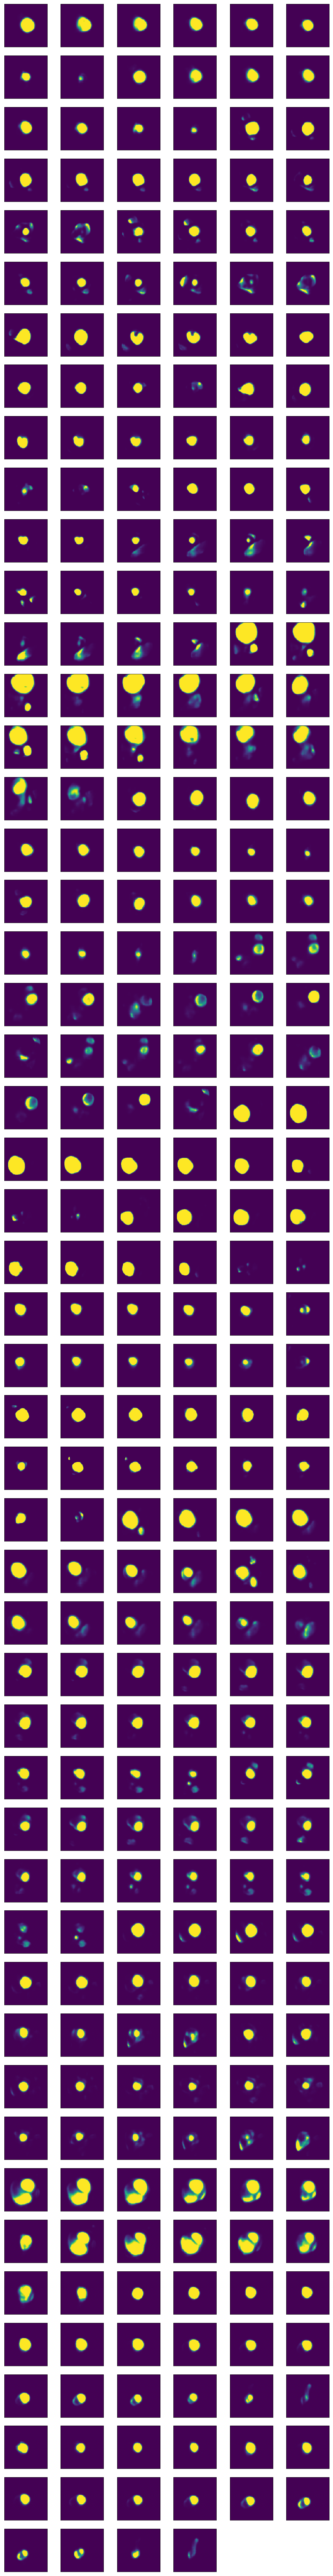

In [24]:
plt.rcParams["figure.figsize"] = (15, 120)
ncols = 6
nrows = np.ceil(valid_set.shape[0]/ncols)
for i in range(valid_set.shape[0]):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(prediction[i, :, :, 0])
    plt.xticks([])
    plt.yticks([])
#     plt.colorbar()
plt.show()